## Ensemble Voting

Ensemble methods enable combining multiple model scores into a single score to create a robust generalized model. Ensemble voting is one of the simplest ways of combining the predictions from multiple machine learning algorithms. It works by first creating multiple standalone models from your training dataset. A Voting Classifier can then be used to wrap your models and average the predictions of the sub-models when asked to make predictions for new data.
 
The predictions of the sub-models can be weighted, but specifying the weights for classifiers manually or even heuristically is difficult. More advanced methods can learn how to best weight the predictions from submodels, but this is called stacking (stacked aggregation) and is currently not provided in scikit-learn.

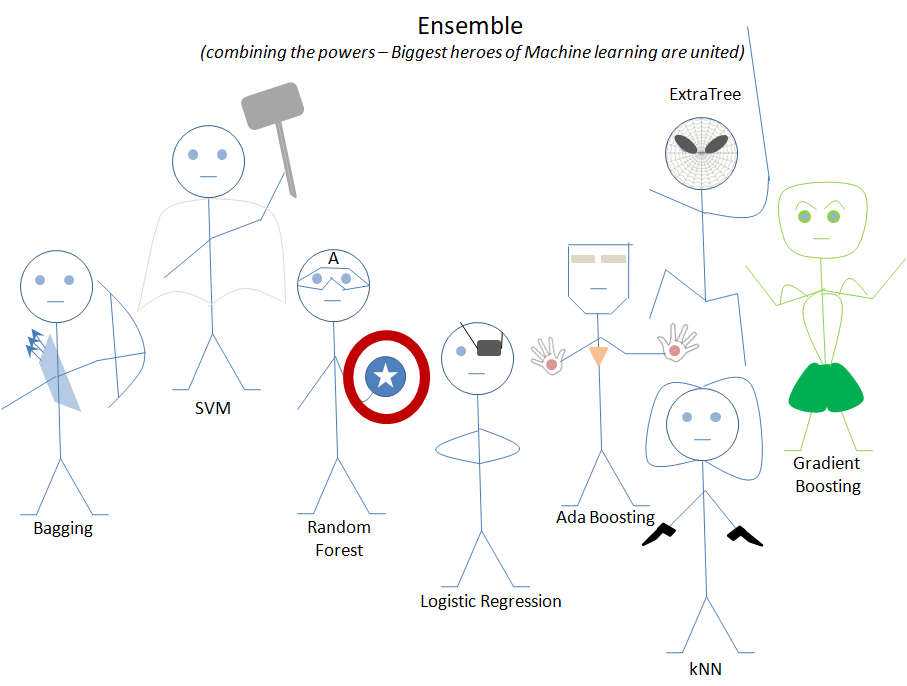

In [1]:
from IPython.display import Image
Image(filename='../Chapter 4 Figures/Ensemble.png', width=800)

In [6]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

# set seed for reproducability
np.random.seed(2017)

import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# currently its available as part of mlxtend and not sklearn
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split

# read the data in
df = pd.read_csv("Data/Diabetes.csv")

X = df.iloc[:,:8]     # independent variables
y = df['class']     # dependent variables

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2017)

LR = LogisticRegression(random_state=2017)
RF = RandomForestClassifier(n_estimators = 100, random_state=2017)
SVM = SVC(random_state=0, probability=True)
KNC = KNeighborsClassifier()
DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(n_estimators = 100)
BC = BaggingClassifier(n_estimators = 100)
GBC = GradientBoostingClassifier(n_estimators = 100)

clfs = []
print('5-fold cross validation:\n')
for clf, label in zip([LR, RF, SVM, KNC, DTC, ABC, BC, GBC], 
                      ['Logistic Regression', 
                       'Random Forest', 
                       'Support Vector Machine',
                       'KNeighbors',
                       'Decision Tree',
                       'Ada Boost',
                       'Bagging',
                       'Gradient Boosting']):
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X, y)    
    clfs.append(md)
    print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_test), y_test)))    

5-fold cross validation:

Train CV Accuracy: 0.76 (+/- 0.03) [Logistic Regression]
Test Accuracy: 0.79 
Train CV Accuracy: 0.74 (+/- 0.03) [Random Forest]
Test Accuracy: 1.00 
Train CV Accuracy: 0.65 (+/- 0.00) [Support Vector Machine]
Test Accuracy: 1.00 
Train CV Accuracy: 0.70 (+/- 0.05) [KNeighbors]
Test Accuracy: 0.84 
Train CV Accuracy: 0.69 (+/- 0.02) [Decision Tree]
Test Accuracy: 1.00 
Train CV Accuracy: 0.73 (+/- 0.04) [Ada Boost]
Test Accuracy: 0.83 
Train CV Accuracy: 0.75 (+/- 0.04) [Bagging]
Test Accuracy: 1.00 
Train CV Accuracy: 0.75 (+/- 0.03) [Gradient Boosting]
Test Accuracy: 0.92 


From above benchmarking we see that 'Logistic Regression', 'Random Forest', 'Bagging', Ada/Gradient Boosting algorithms are giving better accuracy compared to other models. Let's combine non-similar models such as Logistic regression (base model), Random Forest (bagging model) and Gradient boosting (boosting model) to create a robust generalized model.  

In [7]:
# re-building considering only the best performing non-similar models
clfs = []
print('5-fold cross validation:\n')
for clf, label in zip([LR, RF, GBC], 
                      ['Logistic Regression', 
                       'Random Forest', 
                       'Gradient Boosting']):
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X, y)    
    clfs.append(md)
    print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_test), y_test)))    

5-fold cross validation:

Train CV Accuracy: 0.76 (+/- 0.03) [Logistic Regression]
Test Accuracy: 0.79 
Train CV Accuracy: 0.74 (+/- 0.03) [Random Forest]
Test Accuracy: 1.00 
Train CV Accuracy: 0.74 (+/- 0.04) [Gradient Boosting]
Test Accuracy: 0.92 


#### Hard voting vs Soft voting

Majority voting is also known as hard voting. The argmax of the sum of predicted probabilities is known as soft voting. Parameteer 'weights' can be used to assign specific weightage to classifiers. The predicted class probabilities for each classifier are multiplied by the classifier weight, and averaged. Then the final class label is derived from the highest average probability class label. 

Assume we assign equal weight of 1 to all classifiers (see below table). Based on soft voting, the predicted class label is 1, as it has the highest average probability.

Note: Some classifiers of scikit-learn do not support the predict_proba method

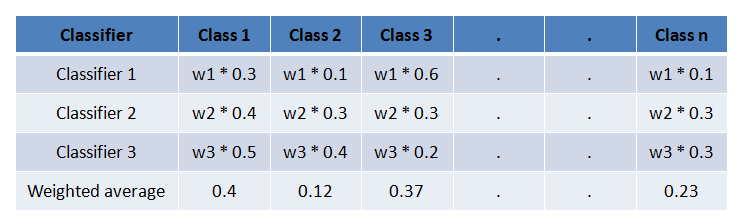

In [4]:
from IPython.display import Image
Image(filename='../Chapter 4 Figures/soft voting.png', width=500)

In [5]:
# ### Ensemble Voting
clfs = []
print('5-fold cross validation:\n')

ECH = EnsembleVoteClassifier(clfs=[LR, RF, GBC], voting='hard')
ECS = EnsembleVoteClassifier(clfs=[LR, RF, GBC], voting='soft', weights=[1,1,1])

for clf, label in zip([ECH, ECS], 
                      ['Ensemble Hard Voting', 
                       'Ensemble Soft Voting']):
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X, y)    
    clfs.append(md)
    print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_test), y_test)))       

5-fold cross validation:

Train CV Accuracy: 0.75 (+/- 0.02) [Ensemble Hard Voting]
Test Accuracy: 0.93 
Train CV Accuracy: 0.76 (+/- 0.02) [Ensemble Soft Voting]
Test Accuracy: 0.95 
